In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
from plot_params import *

indir1 = '/home/hsher/scratch/circ_nextera_iter12/output/'
circ_quant_output = [os.path.join(indir1,f) for f in os.listdir(indir1) if f.endswith('.gtf')]

# the basic rar11 recipe
indir = '/home/hsher/scratch/circ_nextera_iter2/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf') 
                      and f.startswith('HEK_rar11')]

indir3 = '/home/hsher/scratch/circ_nextera/output/'
circ_quant_output += [os.path.join(indir3,f) for f in os.listdir(indir3) if f.endswith('.gtf') 
                      and f.startswith('circseq-bm-rar11-nxt')]



In [2]:
circ_quant_output

['/home/hsher/scratch/circ_nextera_iter12/output/K562_rep2_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/K562_rep1_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/HepG2_rep2_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/HeLa_rep1_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/HepG2_rep1_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/HeLa_rep2_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter2/output/HEK_rar11.gtf',
 '/home/hsher/scratch/circ_nextera/output/circseq-bm-rar11-nxt.gtf']

In [3]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [4]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
mega_anno = []

features = ['seqname', 'start', 'end', 
       'strand', 'circ_type', 'gene_id', 'gene_name', 'gene_type']

for fname in circ_quant_output:
    name = os.path.basename(fname).replace('.gtf', '')
    names.append(name)
    
    circ_df, stat = read_ciri_gtf(fname)
    
    circ_type_count.append(circ_df['circ_type'].value_counts())
    
    junc_ratio_tbl.append(circ_df.set_index('circ_id')['junc_ratio'].astype(float))
    bsj_ratio_tbl.append(circ_df.set_index('circ_id')['bsj'].astype(float))
    fsj_ratio_tbl.append(circ_df.set_index('circ_id')['fsj'].astype(float))
    stats.append(stat.set_index(0))
    mega_anno.append(circ_df.set_index('circ_id')[features])
mega_anno = pd.concat(mega_anno, axis = 0).drop_duplicates()

In [5]:
stats_df = pd.concat(stats, axis = 1).T

In [6]:
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)

In [7]:
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']

In [8]:
stats_df.sort_values('frac_circular')
stats_df.set_index('##Sample', inplace = True)

In [9]:
stats_df

,##Total_Reads,##Mapped_Reads,##Circular_Reads,##version,frac_circular,frac_mapped
##Sample,,,,,,
K562_rep2_rar11,121234652,103575430,2470854,1.1.2,0.023856,0.854338
K562_rep1_rar11,119847686,104673154,1944764,1.1.2,0.018579,0.873385
HepG2_rep2_rar11,117490276,99888226,2944574,1.1.2,0.029479,0.850183
HeLa_rep1_rar11,112922030,98380672,2733644,1.1.2,0.027786,0.871227
HepG2_rep1_rar11,115035274,98453510,3450508,1.1.2,0.035047,0.855855
HeLa_rep2_rar11,118506386,100805144,3549726,1.1.2,0.035214,0.850630
HEK_rar11,288352678,238307158,5730730,1.1.2,0.024048,0.826443
circseq-bm-rar11-nxt,337446430,294910186,4307176,1.1.2,0.014605,0.873947


In [10]:
counts = pd.concat(circ_type_count, axis = 1)
counts.columns = names

In [11]:
bsj = pd.concat(bsj_ratio_tbl, axis = 1)
bsj.columns = names

In [12]:
fsj = pd.concat(fsj_ratio_tbl, axis = 1)
fsj.columns = names

In [13]:
junc = pd.concat(junc_ratio_tbl, axis = 1)
junc.columns = names

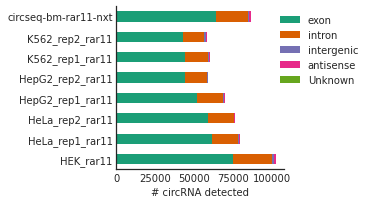

In [14]:
import matplotlib.pyplot as plt
counts.T.sort_index().plot.barh(stacked = True, figsize = (3,3))
plt.xlabel('# circRNA detected')
plt.legend(bbox_to_anchor = (1.5, 1))
sns.despine()
plt.savefig(figdir / '5_n_circles.pdf')

# Overlap between circular RNAs in cell line

In [15]:
bsj

,K562_rep2_rar11,K562_rep1_rar11,HepG2_rep2_rar11,HeLa_rep1_rar11,HepG2_rep1_rar11,HeLa_rep2_rar11,HEK_rar11,circseq-bm-rar11-nxt
circ_id,,,,,,,,
chr1:746436|749381,72.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
chr1:746695|749381,62.0,166.0,NaN,5.0,27.0,113.0,134.0,149.0
chr1:805799|810170,82.0,33.0,124.0,118.0,134.0,153.0,43.0,68.0
chr1:945177|945517,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr1:955923|957025,3.0,NaN,1.0,NaN,NaN,6.0,1.0,NaN
...,...,...,...,...,...,...,...,...
chrX:155506898|155511774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
chrX:155506898|155525464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
chrX:155511673|155514290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [16]:
circname_reproducible = {}
for cell_line in ['K562', 'HepG2', 'HeLa']:
    circname_reproducible[cell_line]=set(bsj.loc[~bsj[f'{cell_line}_rep1_rar11'].isnull()].index).intersection(
                                    set(bsj.loc[~bsj[f'{cell_line}_rep2_rar11'].isnull()].index)
    )
circname_reproducible['HEK293']=set(bsj.loc[~bsj[['HEK_rar11', 'circseq-bm-rar11-nxt']].isnull().any(axis = 1)].index)

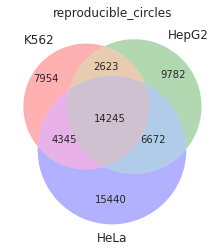

In [17]:
from matplotlib_venn import venn3
venn3([circname_reproducible[p] for p in ['K562', 'HepG2', 'HeLa']]
      , set_labels = ('K562', 'HepG2', 'HeLa'), 
      
      alpha = 0.3
     )
plt.title('reproducible_circles')
plt.savefig(figdir / '5_venn_3cellline.pdf')

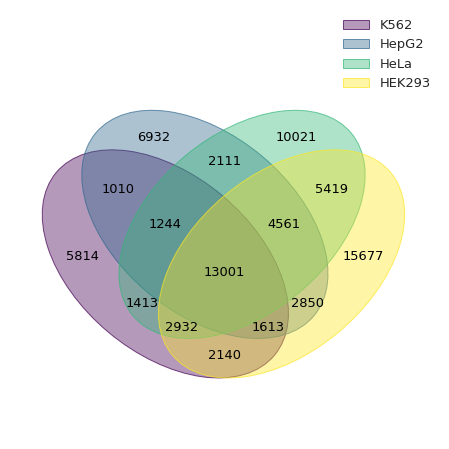

In [18]:
from venn import venn
venn(circname_reproducible)
plt.savefig(figdir / '5_venn_4cellline.pdf')

# Correlating CPM levels

In [19]:
cpm=bsj.div(stats_df['##Total_Reads'], axis = 1)*10**6

/home/hsher/miniconda3/envs/Metadensity/lib/python3.9/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


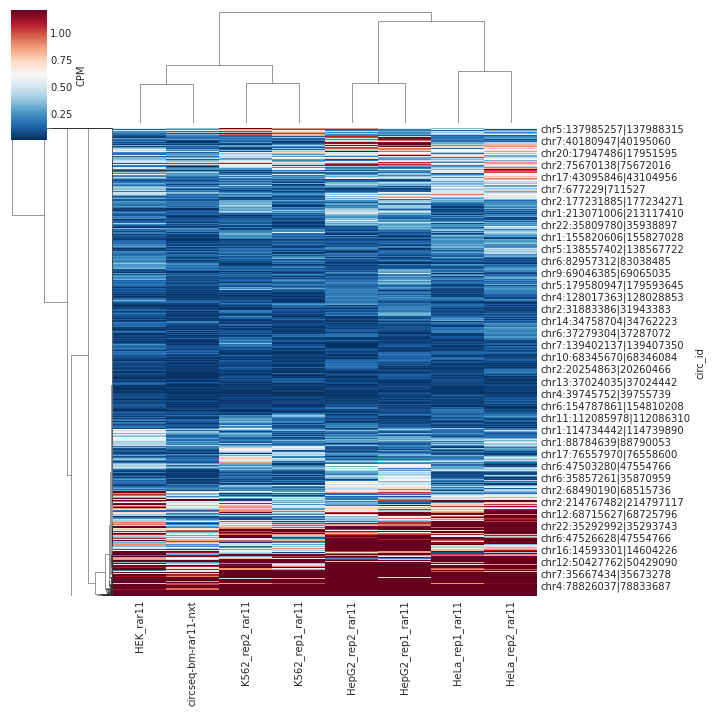

In [20]:
all_expressed = cpm.loc[cpm.isnull().sum(axis = 1)<1]
max_value = all_expressed.mean().median()
sns.clustermap(all_expressed, cmap = 'RdBu_r', vmax = max_value*2, 
              cbar_kws = {'label':'CPM'})
plt.savefig(figdir / '5_cell_line_CPM_clust.pdf')

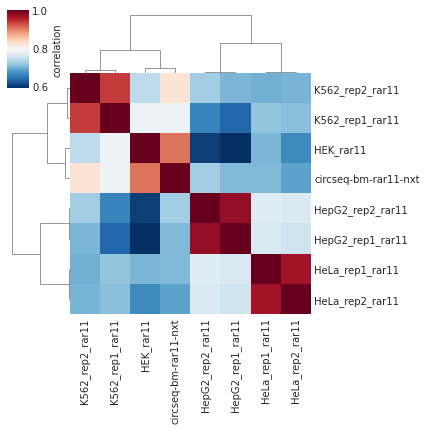

In [21]:
from scipy.spatial.distance import pdist, squareform
corr = pd.DataFrame(1-squareform(pdist(all_expressed.T, 'correlation')),
                    index = all_expressed.columns,
                    columns = all_expressed.columns)

sns.clustermap(corr, metric = 'correlation', cmap = 'RdBu_r', figsize = (6,6), cbar_kws = {'label': 'correlation'})
plt.savefig(figdir / '5_cell_line_CPM_corr.pdf')

# Other analysis: what contributes to differentially expressed circles
- linear RNA expression: download from CCLE [here](https://www.ebi.ac.uk/gxa/experiments/E-MTAB-2770/Results)
- [link](https://www.ebi.ac.uk/gxa/experiments-content/E-MTAB-2770/resources/ExperimentDownloadSupplier.RnaSeqBaseline/fpkms.tsv)

- cell type specific casette exons?
- intron lengths

# The same gene express different circles?

In [22]:
cpm.rename({'circseq-bm-rar11-nxt':'HEK_rar11_rep2'}, axis = 1, inplace = True)

In [23]:
mega_anno.loc[cpm.loc[cpm.isnull().sum(axis = 1)<3].index]['gene_name'].value_counts()

SMARCC1                 65
BIRC6                   57
PPP6R3                  47
PDS5A                   43
USP34                   43
                        ..
PAK1                     1
NDUFC2-KCTD14,NDUFC2     1
PCF11                    1
ANKRD42,AP000873.5       1
MBNL3                    1
Name: gene_name, Length: 6370, dtype: int64

In [24]:
coords = BedTool('/home/hsher/gencode_coords/gencode.v35.annotation.gff3')
from collections import defaultdict
exon_dict = defaultdict(lambda: list())
for c in coords:
    if c[2]=='exon':
        exon_dict[c.attrs['gene_name']].append([c.start, c.end])

In [25]:
def plot_bsj(gene):
    sub = cpm.loc[mega_anno.loc[mega_anno['gene_name']==gene].index].fillna(0)
    
    
    clines = sorted(list(sub.columns))
    
    max_cpm = sub.max().max()
    sub['start']=mega_anno['start']
    sub['end']=mega_anno['end']
    
    print(clines)
    f, ax = plt.subplots(1,int(len(clines)/2),  figsize = (int(3*len(clines)/2),3), sharex = True, sharey = True)
    for i,c in enumerate(clines): 
        if i%2==0:
            ax[i//2].scatter(sub['start'], sub['end'], (sub[c]/max_cpm)*10, label = c)
        else:
            ax[i//2].scatter(sub['end'],sub['start'],  (sub[c]/max_cpm)*10, label = c)
        ax[i//2].set_title(c.split('_')[0])
        ax[i//2].text(sub['start'].min(), sub['end'].max(), 'rep1')
        ax[i//2].text(sub['end'].max(), sub['start'].min(), 'rep2')
    sns.despine()
    
    # _ = [a.legend() for a in ax]
    _ = [a.set_ylabel('BSJ start/end') for a in ax]
    _ = [a.set_xlabel('BSJ start/end') for a in ax]
    
    min_ax = min([i[0] for i in exon_dict[gene]])
    max_ax = max([i[1] for i in exon_dict[gene]])
    # for a in ax:
    #     for exon in exon_dict[gene]:
    #         #print(exon, min_ax, max_ax)
    #         # if exon[0]>sub['start'].min():
    #         a.plot([min_ax]*2, exon, linewidth=7.0, color = 'lightgrey')
    #         a.plot(exon, [min_ax]*2,  linewidth=7.0, color = 'lightgrey')
    #         a.axhspan(exon[0], exon[1], xmin=min_ax, xmax=max_ax, color = 'lightgrey')
    #         a.axvspan(exon[0], exon[1], ymin=min_ax, ymax=max_ax, color = 'lightgrey')
            
    _ = [a.plot([min_ax, max_ax], [min_ax, max_ax], '--', color = 'black') for a in ax]
    
    plt.suptitle(gene)

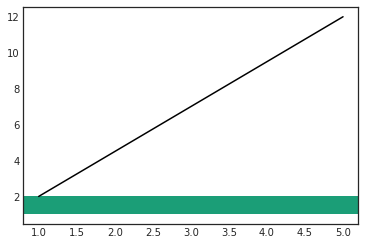

In [26]:

plt.plot([1,1,5], [2,2,12], color = 'black')
plt.axhspan(1,2)

['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


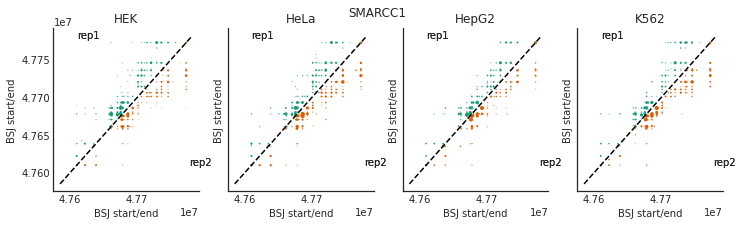

In [27]:
plot_bsj('SMARCC1')
plt.savefig(figdir / '5_BSJ_in_SMARCC1.pdf')

['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


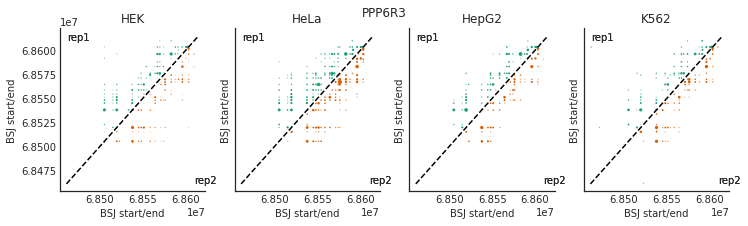

In [28]:
plot_bsj('PPP6R3')
plt.savefig(figdir / '5_BSJ_in_PPP6R3.pdf')

['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


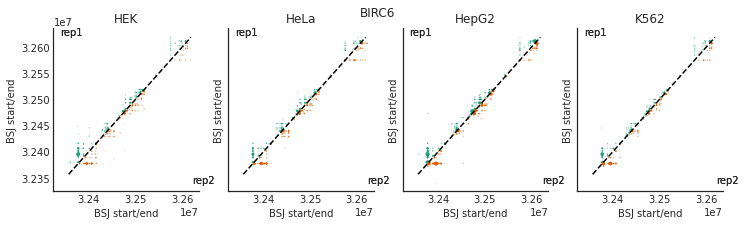

In [29]:
plot_bsj('BIRC6')
plt.savefig(figdir / '5_BSJ_in_BIRC6.pdf')

['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


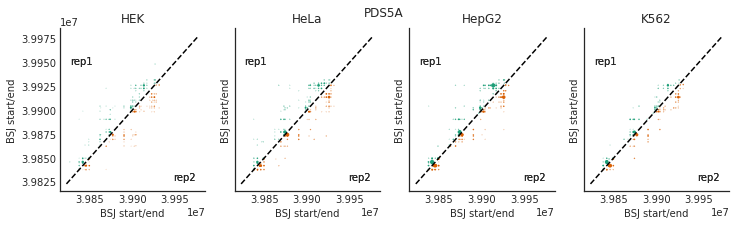

In [30]:
plot_bsj('PDS5A')
plt.savefig(figdir / '5_BSJ_in_PDS5A.pdf')

['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


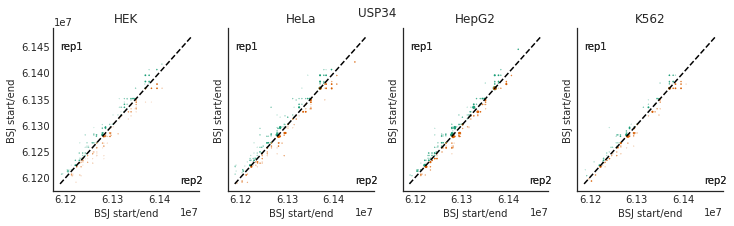

In [31]:
plot_bsj('USP34')
plt.savefig(figdir / '5_BSJ_in_USP34.pdf')

In [32]:
linear_rpkm = pd.read_csv('/projects/ps-yeolab5/hsher/ccle_datasets/CCLE_RNAseq_genes_rpkm_20180929.gct.gz',
                     skiprows = 2,
                     sep = '\t')

In [33]:
linear_rpkm.drop_duplicates(subset = ['Description'], inplace = True)

In [34]:
gene_length = {}
for c in coords:
    if c[2]=='gene':
        gene_length[c.attrs['gene_name']]=c.end-c.start

In [35]:
linear_rpkm['length']=linear_rpkm['Description'].map(gene_length)

In [36]:
cols = ['HEPG2_LIVER','K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE','HEKTE_KIDNEY','HELA_CERVIX']
linear_cpm = []
for c in cols:
    cpm_value=linear_rpkm.set_index('Description')[c]*linear_rpkm.set_index('Description')['length']
    cpm_value.name = c
    linear_cpm.append(cpm_value)
linear_cpm = pd.concat(linear_cpm, axis = 1)

In [37]:
cpm2 = cpm.copy()
cpm2['gene_name']=mega_anno['gene_name']
circ_cpm_sum_pergene = cpm2.groupby(by = 'gene_name').sum()
circ_cpm_sum_pergene = pd.concat([linear_cpm,circ_cpm_sum_pergene],axis = 1).dropna()

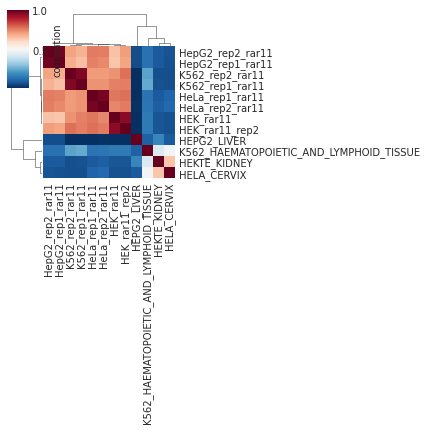

In [38]:
corr = pd.DataFrame(1-squareform(pdist(circ_cpm_sum_pergene.T, 'correlation')),
                    index = circ_cpm_sum_pergene.columns,
                    columns = circ_cpm_sum_pergene.columns)

sns.clustermap(corr, metric = 'correlation', cmap = 'RdBu_r', figsize = (6,6), cbar_kws = {'label': 'correlation'})
# plt.savefig(figdir / '5_cell_line_CPM_corr.pdf')



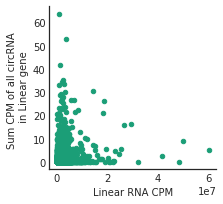

In [39]:
circ_cpm_sum_pergene.plot.scatter(x = 'K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
                                  y = 'K562_rep1_rar11',
                                 figsize = (3,3))
plt.ylabel('Sum CPM of all circRNA \n in Linear gene')
plt.xlabel('Linear RNA CPM')
sns.despine()

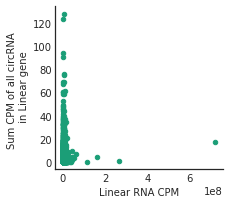

In [40]:
circ_cpm_sum_pergene.plot.scatter(x = 'HEPG2_LIVER',
                                  y = 'HepG2_rep1_rar11',
                                 figsize = (3,3))
plt.ylabel('Sum CPM of all circRNA \n in Linear gene')
plt.xlabel('Linear RNA CPM')
sns.despine()

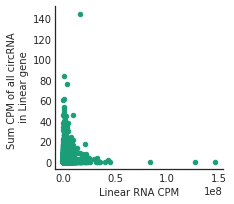

In [41]:
circ_cpm_sum_pergene.plot.scatter(x = 'HELA_CERVIX',
                                  y = 'HeLa_rep1_rar11',
                                 figsize = (3,3))
plt.ylabel('Sum CPM of all circRNA \n in Linear gene')
plt.xlabel('Linear RNA CPM')
sns.despine()

# Differentially expressed circles

In [70]:
de_path = Path('/projects/ps-yeolab5/hsher/Tao_circ_cellline_de/output/unadjusted_comparison')

de_dict = {}
for f in de_path.glob('*gtf.tsv'):
    df = pd.read_csv(f, sep = ',', index_col = 0)
    
    df = df.merge(mega_anno, left_index = True, right_index = True)
    de_dict[f.name.replace('.gtf.tsv', '')] = df

In [44]:
de_stat = []
for comparison in de_dict:
    df = de_dict[comparison]
    up = df.loc[df['DE']==1, 'circ_type'].value_counts()
    up['type']='upregulated'
    up['name']=comparison
    down = df.loc[df['DE']==-1,'circ_type'].value_counts()
    down['type']='upregulated'
    down['name']=comparison
    
    de_stat.append(up)
    de_stat.append(down)
    
de_stat = pd.concat(de_stat, axis = 1).fillna(0)
    
    

In [45]:
de_stat

,circ_type,circ_type,circ_type,circ_type,circ_type,circ_type
exon,2177,495,860,902,1420,330
intron,676,84,448,133,405,76
intergenic,48,7,65,10,24,9
antisense,20,8,32,8,3,6
Unknown,3,0,8,0,0,0
type,upregulated,upregulated,upregulated,upregulated,upregulated,upregulated
name,HepG2.HEK,HepG2.HEK,K562.HEK,K562.HEK,HeLa.HEK,HeLa.HEK


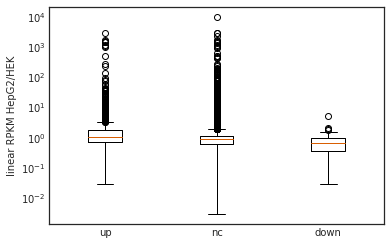

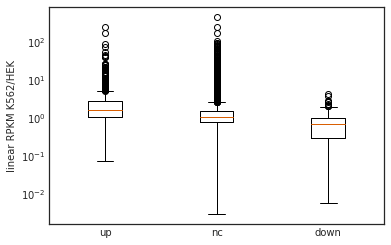

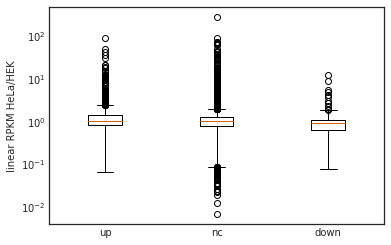

In [48]:

for comparison in de_dict:
    df = de_dict[comparison]
    cond1, cond2 = comparison.split('.')
    cond1_col = [c for c in cols if cond1.upper() in c][0]
    cond2_col = [c for c in cols if cond2.upper() in c][0]
    
    up = df.loc[df['DE']==1, 'gene_name'].dropna().unique()
    nc = df.loc[df['DE']==0,'gene_name'].dropna().unique()
    down = df.loc[df['DE']==-1,'gene_name'].dropna().unique()
    
    linear_fc_up = (linear_rpkm.loc[linear_rpkm['Description'].isin(up), cond1_col]+1)/(linear_rpkm.loc[linear_rpkm['Description'].isin(up), cond2_col]+1)
    linear_fc_nc = (linear_rpkm.loc[linear_rpkm['Description'].isin(nc), cond1_col]+1)/(linear_rpkm.loc[linear_rpkm['Description'].isin(nc), cond2_col]+1)
    linear_fc_down = (linear_rpkm.loc[linear_rpkm['Description'].isin(down), cond1_col]+1)/(linear_rpkm.loc[linear_rpkm['Description'].isin(down), cond2_col]+1)
    
    plt.boxplot([linear_fc_up, linear_fc_nc, linear_fc_down])
    plt.yscale('log')
    plt.xticks([1,2,3 ], ['up', 'nc','down'])
    plt.ylabel(f'linear RPKM {cond1}/{cond2}')
    plt.show()
    

In [49]:
diff_set = {}
for comparison in de_dict:
    df = de_dict[comparison]
    diff = set(df.loc[(df['DE']==1)|(df['DE']==-1), 'gene_name'].dropna().unique())
    
    diff_set[comparison]=diff

In [50]:
very_different = diff_set['HepG2.HEK'].intersection(diff_set['K562.HEK']).intersection(diff_set['HeLa.HEK'])

In [65]:
linear_rpkm.loc[linear_rpkm['Description'].isin(very_different)
               ].set_index('Description')[cols].median(axis = 1).sort_values().iloc[-50:]

Description
TOPBP1      17.933350
FANCL       19.676000
TFPI        20.101450
HUWE1       20.290300
PSMD5       20.319530
PPP6R3      20.356700
ZFAND3      20.501550
NEAT1       20.830550
CPSF6       20.866050
MLH1        21.317000
ADIPOR2     21.412100
PALLD       21.882638
TRAM2       21.973000
PAK2        22.179650
PTPN12      22.253300
GLS         24.447750
UBP1        24.456250
NPEPPS      25.597000
REEP5       25.631700
ATXN10      25.669150
UGP2        26.913100
ASPH        29.169600
OSBPL9      29.466900
DCTD        30.531750
VMP1        31.187800
HADHB       31.856100
TSN         32.835600
PTPN11      33.072250
YME1L1      34.875400
MRPL39      35.634500
AP3S1       39.061350
HP1BP3      40.739050
MTCH2       41.144350
PRKDC       42.807350
CRIM1       43.708400
MALAT1      46.531750
UBA2        51.196950
TXNRD1      52.412350
PICALM      58.968600
APRT        72.008300
GAS5        81.235250
GDI2        83.598100
ST13        85.890950
RAB1A       86.753300
SLC38A2    100.16960

['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


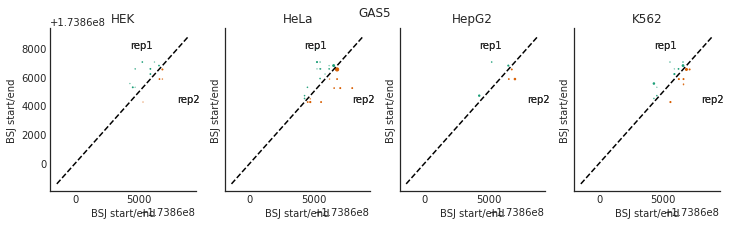

In [66]:
plot_bsj('GAS5')

['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


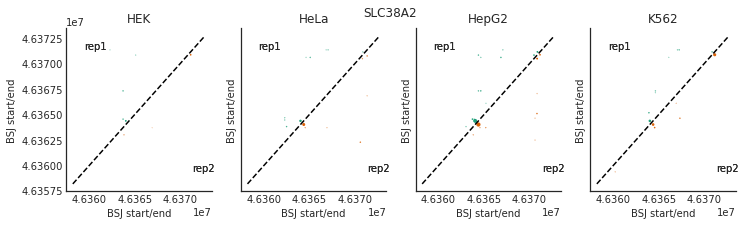

In [68]:
plot_bsj('SLC38A2')

['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


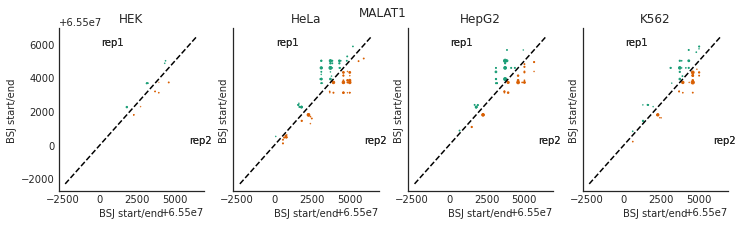

In [67]:
plot_bsj('MALAT1')

['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


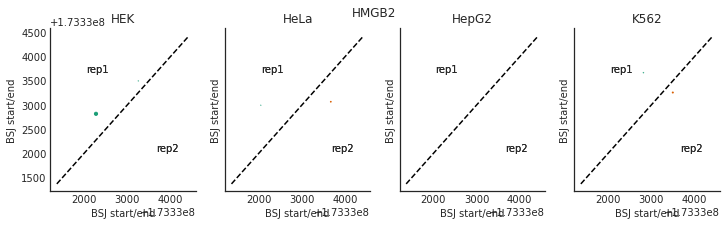

In [64]:
plot_bsj('HMGB2')

['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


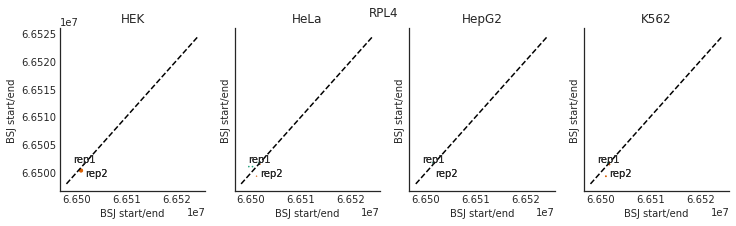

In [61]:
plot_bsj('RPL4')

['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


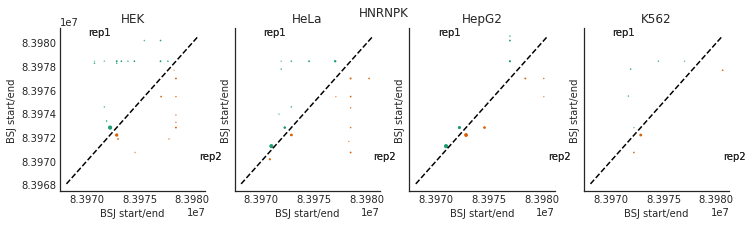

In [62]:
plot_bsj('HNRNPK')

['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


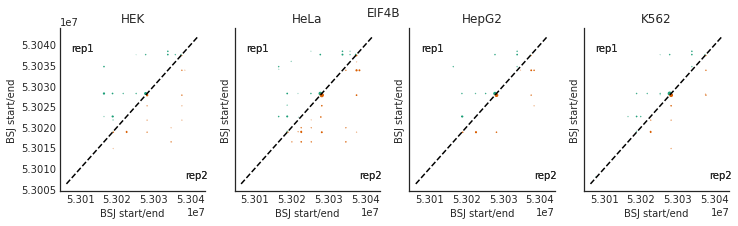

In [63]:
plot_bsj('EIF4B')

['HEK_rar11', 'HEK_rar11_rep2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


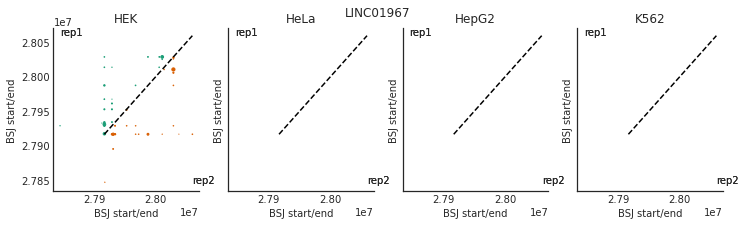

In [55]:
plot_bsj('LINC01967')

In [76]:
mega = [de_dict[name][['logFC', 'FDR']].rename({
    'logFC':f'logFC_{name}',
    'FDR':f'FDR_{name}',
    
    }, axis = 1)
    for name in de_dict]

In [77]:
mega = pd.concat(mega,axis = 1)


In [81]:
mega.merge(mega_anno, left_index = True, right_index = True)

,logFC_HepG2.HEK,FDR_HepG2.HEK,logFC_K562.HEK,FDR_K562.HEK,logFC_HeLa.HEK,FDR_HeLa.HEK,seqname,start,end,strand,circ_type,gene_id,gene_name,gene_type
chr16:87901912|87902520,14.657465,1.412748e-23,5.470175,5.001382e-01,NaN,NaN,chr16,87901912.0,87902520.0,-,exon,ENSG00000174990.8,CA5A,protein_coding
chr5:170878097|170896115,-15.603578,5.616636e-23,-15.663549,4.511792e-23,0.171481,0.836988,chr5,170878097.0,170896115.0,+,exon,ENSG00000204764.14,RANBP17,protein_coding
chrY:19587210|19587507,13.572371,4.742956e-19,NaN,NaN,NaN,NaN,chrY,19587210.0,19587507.0,+,exon,ENSG00000131002.12,TXLNGY,transcribed_unprocessed_pseudogene
chr19:6702127|6702579,13.431294,1.368488e-18,NaN,NaN,6.965018,0.155481,chr19,6702127.0,6702579.0,-,exon,ENSG00000125730.17,C3,protein_coding
chrY:2953909|2961646,13.360315,2.157068e-18,NaN,NaN,NaN,NaN,chrY,2953909.0,2961646.0,+,exon,ENSG00000067646.12,ZFY,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:85971293|85981806,NaN,NaN,NaN,NaN,3.091437,0.503295,chrX,85971293.0,85981806.0,-,exon,ENSG00000188419.14,CHM,protein_coding
chrX:9082579|9085164,NaN,NaN,NaN,NaN,3.091437,0.503295,chrX,9082579.0,9085164.0,-,intron,ENSG00000177138.17,FAM9B,protein_coding
chrX:9640273|9697429,NaN,NaN,NaN,NaN,3.091437,0.503295,chrX,9640273.0,9697429.0,+,exon,ENSG00000101849.17,TBL1X,protein_coding
chrX:96955148|96965207,NaN,NaN,NaN,NaN,3.091437,0.503295,chrX,96955148.0,96965207.0,+,intron,ENSG00000147202.18,DIAPH2,protein_coding


In [82]:
mega.to_csv(figdir/'cell_type_de_circ.csv')

In [83]:
figdir

PosixPath('/home/hsher/scratch/circular_fig')